Need to fix the lookup early! indexes are all over the place

In [1]:
from pathlib import Path

import tqdm
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import random as random

from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm, tqdm_notebook
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading and cleaning

In [2]:
df = pd.read_csv("dota-2-matches\players.csv")

In [3]:
lambda x: 'true' if x <= 2.5 else 'false'

<function __main__.<lambda>(x)>

In [4]:
df = df[['match_id','hero_id','player_slot']]
df.head()

,match_id,hero_id,player_slot
0,0,86,0
1,0,51,1
2,0,83,2
3,0,11,3
4,0,67,4


In [5]:
df['player_slot'].unique()

array([  0,   1,   2,   3,   4, 128, 129, 130, 131, 132], dtype=int64)

In [6]:
df['player_slot'] = df['player_slot'].apply(lambda x: x -123 if x >= 128 else x)

Add a row for the team - this will feed the neural network

In [7]:
df['team'] = df['player_slot'].apply(lambda x: 0 if x <= 4 else 1)

In [8]:
df.head(10)

,match_id,hero_id,player_slot,team
0,0,86,0,0
1,0,51,1,0
2,0,83,2,0
3,0,11,3,0
4,0,67,4,0
5,0,106,5,1
6,0,102,6,1
7,0,46,7,1
8,0,7,8,1
9,0,73,9,1


In [9]:
df['player_slot'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

### No missing values

In [10]:
df[df.isna().any(axis=1)]

,match_id,hero_id,player_slot,team


Remove games where there are fewer than 10 players

In [11]:
df_counts = df.groupby(['match_id']).count()
df_counts.head()


,hero_id,player_slot,team
match_id,,,
0,10,10,10
1,10,10,10
2,10,10,10
3,10,10,10
4,10,10,10


All matches contain exactly 10 players

In [12]:
df_counts[df_counts['hero_id'] != 10]

,hero_id,player_slot,team
match_id,,,


Reading in hero dataframe and joining to original data

In [13]:
df_hero_names = pd.read_csv("dota-2-matches/hero_names.csv")

In [14]:
df_hero_names.head()

,name,hero_id,localized_name
0,npc_dota_hero_antimage,1,Anti-Mage
1,npc_dota_hero_axe,2,Axe
2,npc_dota_hero_bane,3,Bane
3,npc_dota_hero_bloodseeker,4,Bloodseeker
4,npc_dota_hero_crystal_maiden,5,Crystal Maiden


Reindexing

In [15]:
df_merged = df.merge(df_hero_names, on="hero_id").sort_values(by=["match_id", "player_slot"])

In [16]:
df_merged.head()

,match_id,hero_id,player_slot,team,name,localized_name
0,0,86,0,0,npc_dota_hero_rubick,Rubick
8183,0,51,1,0,npc_dota_hero_rattletrap,Clockwerk
12484,0,83,2,0,npc_dota_hero_treant,Treant Protector
14226,0,11,3,0,npc_dota_hero_nevermore,Shadow Fiend
31233,0,67,4,0,npc_dota_hero_spectre,Spectre


In [17]:
def func(x):
    if x == 113:
        return x-4
    elif x > 107:
        return x-3
    elif x > 23:
        return x-2
    else:
        return x-1

In [18]:
df_merged['temp_id'] = df_merged['hero_id'].apply(func)

In [19]:
df_merged.head()

,match_id,hero_id,player_slot,team,name,localized_name,temp_id
0,0,86,0,0,npc_dota_hero_rubick,Rubick,84
8183,0,51,1,0,npc_dota_hero_rattletrap,Clockwerk,49
12484,0,83,2,0,npc_dota_hero_treant,Treant Protector,81
14226,0,11,3,0,npc_dota_hero_nevermore,Shadow Fiend,10
31233,0,67,4,0,npc_dota_hero_spectre,Spectre,65


Checking lengths of new column is the same after remapping

In [20]:
len(sorted(df_merged['temp_id'].unique().tolist()))

110

In [21]:
len(df_merged['hero_id'].unique().tolist())

110

In [22]:
n_heroes = len(sorted(df_merged['temp_id'].unique().tolist()))

In [23]:
df_merged.head()

,match_id,hero_id,player_slot,team,name,localized_name,temp_id
0,0,86,0,0,npc_dota_hero_rubick,Rubick,84
8183,0,51,1,0,npc_dota_hero_rattletrap,Clockwerk,49
12484,0,83,2,0,npc_dota_hero_treant,Treant Protector,81
14226,0,11,3,0,npc_dota_hero_nevermore,Shadow Fiend,10
31233,0,67,4,0,npc_dota_hero_spectre,Spectre,65


In [24]:
# np.random.choice(range(len(df_merged)), int(len(df_merged)*0.8), replace=False)

In [25]:
df_first9 = df_merged[df_merged['player_slot'] != 9]
df_final_pick = df_merged[df_merged['player_slot'] == 9]


In [26]:
df_first9.head()

,match_id,hero_id,player_slot,team,name,localized_name,temp_id
0,0,86,0,0,npc_dota_hero_rubick,Rubick,84
8183,0,51,1,0,npc_dota_hero_rattletrap,Clockwerk,49
12484,0,83,2,0,npc_dota_hero_treant,Treant Protector,81
14226,0,11,3,0,npc_dota_hero_nevermore,Shadow Fiend,10
31233,0,67,4,0,npc_dota_hero_spectre,Spectre,65


In [27]:
df_final_pick.head()

,match_id,hero_id,player_slot,team,name,localized_name,temp_id
66101,0,73,9,1,npc_dota_hero_alchemist,Alchemist,71
37894,1,106,9,1,npc_dota_hero_ember_spirit,Ember Spirit,104
150789,2,85,9,1,npc_dota_hero_undying,Undying,83
197883,3,47,9,1,npc_dota_hero_viper,Viper,45
95496,4,21,9,1,npc_dota_hero_windrunner,Windranger,20


In [28]:
len(df_final_pick)


49997

In [29]:
len(df_first9)/9

49996.22222222222

In [30]:
df_merged['hero_id'][0]

86

In [31]:
df_other_picks = pd.DataFrame(df_first9.groupby("match_id")['temp_id'].agg(list).reset_index())
df_other_picks.rename(columns={"temp_id": "heroes"}, inplace=True)
df_teams = pd.DataFrame(df_first9.groupby("match_id")['team'].agg(list).reset_index())
df_teams.rename(columns={"team": "teams"}, inplace=True)

In [32]:
df_final_pick.head()

,match_id,hero_id,player_slot,team,name,localized_name,temp_id
66101,0,73,9,1,npc_dota_hero_alchemist,Alchemist,71
37894,1,106,9,1,npc_dota_hero_ember_spirit,Ember Spirit,104
150789,2,85,9,1,npc_dota_hero_undying,Undying,83
197883,3,47,9,1,npc_dota_hero_viper,Viper,45
95496,4,21,9,1,npc_dota_hero_windrunner,Windranger,20


In [33]:
df_other_picks.head()

,match_id,heroes
0,0,"[84, 49, 81, 10, 65, 104, 100, 44, 6]"
1,1,"[6, 80, 69, 37, 20, 71, 21, 4, 65]"
2,2,"[49, 106, 8, 39, 25, 36, 6, 9, 11]"
3,3,"[48, 42, 30, 24, 37, 76, 18, 29, 38]"
4,4,"[7, 37, 53, 85, 67, 99, 98, 21, 65]"


In [34]:
# the order shouldn't matter here except for the teams, since it will always be predicting the final dire pick
# this is the same as using different heroes ids for each hero on the teams....?
df_teams.head()

,match_id,teams
0,0,"[0, 0, 0, 0, 0, 1, 1, 1, 1]"
1,1,"[0, 0, 0, 0, 0, 1, 1, 1, 1]"
2,2,"[0, 0, 0, 0, 0, 1, 1, 1, 1]"
3,3,"[0, 0, 0, 0, 0, 1, 1, 1, 1]"
4,4,"[0, 0, 0, 0, 0, 1, 1, 1, 1]"


In [35]:
df_final_pick.reset_index(inplace=True)

In [36]:
df_final = pd.concat([df_other_picks, df_teams, df_final_pick], axis=1)

In [37]:
df_final = df_final.loc[:,~df_final.columns.duplicated()].drop(['index', 'player_slot','name','localized_name'], axis=1)

In [38]:
df_final.head()

,match_id,heroes,teams,hero_id,team,temp_id
0,0,"[84, 49, 81, 10, 65, 104, 100, 44, 6]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",73.0,1.0,71.0
1,1,"[6, 80, 69, 37, 20, 71, 21, 4, 65]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",106.0,1.0,104.0
2,2,"[49, 106, 8, 39, 25, 36, 6, 9, 11]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",85.0,1.0,83.0
3,3,"[48, 42, 30, 24, 37, 76, 18, 29, 38]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",47.0,1.0,45.0
4,4,"[7, 37, 53, 85, 67, 99, 98, 21, 65]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",21.0,1.0,20.0


We will now use the team and the heroes present to predict the 

In [39]:
np.set_printoptions(threshold=sys.maxsize)
np.eye(n_heroes)[df_final['heroes'][1]]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

In [40]:
df_final.tail(10)

,match_id,heroes,teams,hero_id,team,temp_id
49990,49990,"[1, 98, 73, 79, 10, 107, 37, 9, 25]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",100.0,1.0,98.0
49991,49991,"[91, 102, 6, 48, 22, 60, 105, 17, 86]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",21.0,1.0,20.0
49992,49992,"[12, 84, 6, 11, 98, 71, 29, 33, 23]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",112.0,1.0,109.0
49993,49993,"[18, 73, 13, 2, 32, 37, 5, 71, 28]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",71.0,1.0,69.0
49994,49994,"[42, 88, 19, 95, 104, 96, 30, 27, 67]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",23.0,1.0,22.0
49995,49995,"[71, 84, 20, 19, 13, 30, 6, 106, 33]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",3.0,1.0,2.0
49996,49996,"[91, 72, 98, 30, 83, 34, 0, 109, 58]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",53.0,1.0,51.0
49997,49997,"[98, 66, 73, 37, 42, 26, 100, 20, 8]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",NaN,NaN,NaN
49998,49998,"[54, 48, 1, 70, 28, 44, 6, 27, 42]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",NaN,NaN,NaN
49999,49999,"[92, 18, 66, 33, 20, 98, 8, 88, 71]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",NaN,NaN,NaN


In [41]:
df_final[df_final.isna().any(axis=1)]

,match_id,heroes,teams,hero_id,team,temp_id
49997,49997,"[98, 66, 73, 37, 42, 26, 100, 20, 8]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",NaN,NaN,NaN
49998,49998,"[54, 48, 1, 70, 28, 44, 6, 27, 42]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",NaN,NaN,NaN
49999,49999,"[92, 18, 66, 33, 20, 98, 8, 88, 71]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",NaN,NaN,NaN


In [42]:
df_final.head()

,match_id,heroes,teams,hero_id,team,temp_id
0,0,"[84, 49, 81, 10, 65, 104, 100, 44, 6]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",73.0,1.0,71.0
1,1,"[6, 80, 69, 37, 20, 71, 21, 4, 65]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",106.0,1.0,104.0
2,2,"[49, 106, 8, 39, 25, 36, 6, 9, 11]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",85.0,1.0,83.0
3,3,"[48, 42, 30, 24, 37, 76, 18, 29, 38]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",47.0,1.0,45.0
4,4,"[7, 37, 53, 85, 67, 99, 98, 21, 65]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",21.0,1.0,20.0


Seems like some rows don't have enough players! Just dropping them

In [43]:
for i in range(len(df_final)):
    if len(df_final['heroes'][i]) != 9:
        df_final.drop(i, axis=0, inplace=True)

In [44]:
df_final = df_final.reset_index(drop=True)

In [45]:
df[df['match_id'] == 49999]

,match_id,hero_id,player_slot,team
499990,49999,94,0,0
499991,49999,19,1,0
499992,49999,68,2,0
499993,49999,35,3,0
499994,49999,21,4,0
499995,49999,100,5,1
499996,49999,9,6,1
499997,49999,90,7,1
499998,49999,73,8,1
499999,49999,53,9,1


Just cleaning up some rounding issues

In [46]:
df_final['hero_id'][(df_final['match_id']==49997)] = 23
df_final['team'][(df_final['match_id']==49997)] = 1
df_final['temp_id'][(df_final['match_id']==49997)] = 22

df_final['hero_id'][(df_final['match_id']==49998)] = 3
df_final['team'][(df_final['match_id']==49998)] = 1
df_final['temp_id'][(df_final['match_id']==49998)] = 2

df_final['hero_id'][(df_final['match_id']==49999)] = 53
df_final['team'][(df_final['match_id']==49999)] = 1
df_final['temp_id'][(df_final['match_id']==49999)] = 51


C:\Users\roder\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\roder\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\roder\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\roder\Anac

In [92]:
df_final.head()

,match_id,heroes,teams,hero_id,team,temp_id
0,0,"[84, 49, 81, 10, 65, 104, 100, 44, 6]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",73.0,1.0,71
1,1,"[6, 80, 69, 37, 20, 71, 21, 4, 65]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",106.0,1.0,104
2,2,"[49, 106, 8, 39, 25, 36, 6, 9, 11]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",85.0,1.0,83
3,3,"[48, 42, 30, 24, 37, 76, 18, 29, 38]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",47.0,1.0,45
4,4,"[7, 37, 53, 85, 67, 99, 98, 21, 65]","[0, 0, 0, 0, 0, 1, 1, 1, 1]",21.0,1.0,20


In [48]:
df_final['temp_id'] = df_final.temp_id.astype(int)

In [49]:
len(df_final['temp_id'].unique())
max(df_final['temp_id'].unique())

109

In [50]:
df_final.iloc[720]

match_id                                     721
heroes      [15, 16, 94, 65, 13, 42, 73, 20, 37]
teams                [0, 0, 0, 0, 0, 1, 1, 1, 1]
hero_id                                       86
team                                           1
temp_id                                       84
Name: 720, dtype: object

In [51]:
ds = [[np.eye(n_heroes)[df_final['heroes'][i]], df_final['temp_id'][i]] for i in range(len(df_final))]

In [52]:
train_ds = ds[0:int(0.8*len(ds))]
test_ds = ds[int(0.8*len(ds)):]

print(len(train_ds))
print(len(test_ds))

39974
9994


In [53]:
ds[0][0].size

990

In [54]:
# can see this is now the right format for trainloader
train_loader = DataLoader(ds, batch_size=64)


In [55]:
# checking it works for one
for i, (X,y) in enumerate(train_loader):
    print(X.size())
#     print(X[i])
#     print(y[i])
    print(X[i].dtype)
    print(y[i].dtype)
    break

torch.Size([64, 9, 110])
torch.float64
torch.int32


In [56]:
train_data_full = DataLoader(train_ds, batch_size=len(train_ds))
test_data_full = DataLoader(test_ds, batch_size=len(test_ds))
all_data = DataLoader(ds, batch_size=len(ds))

In [57]:
class linear_net(nn.Module):
    def __init__(self):
        super(linear_net, self).__init__()
        self.layer1 = nn.Linear(9 * n_heroes, 300)
        self.layer2 = nn.Linear(300, 200)
        self.layer3 = nn.Linear(200, 150)
        self.layer4 = nn.Linear(150, 110)
        
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        x = x.float().to(device)
        x = x.view(-1, 9 * 110)
        x = self.dropout(F.relu(self.layer1(x)))
        x = self.dropout(F.relu(self.layer2(x)))
        x = self.dropout(F.relu(self.layer3(x)))
        x = self.layer4(x)
        return F.log_softmax(x, dim=1)

In [58]:
t = torch.tensor([4,2,5,6,4,5,7,2])
t.argmax()
res = torch.topk(t, k=3).indices.tolist()
print(res)
u = torch.tensor([6])
u.item() in res

[6, 3, 2]


True

In [59]:
def get_accuracy(model, data_to_test, criterion, return_loss = True, return_predictions=False):
    with torch.no_grad():
        for i, (X_testing, y_testing) in enumerate(data_to_test):
            y_testing = y_testing.type(torch.LongTensor)
            predictions_testing = model(X_testing)
            if return_loss:
                test_loss = criterion(predictions_testing, y_testing)
            total_testing = 0
            correct_testing = 0
            for i in range(len(predictions_testing)):
                # checking to see if the correct hero is in one of 5 top predictions!
                if  y_testing[i].item() in torch.topk(predictions_testing[i], k=10).indices.tolist():
                    correct_testing += 1
                total_testing += 1
    
    if return_predictions:
        if return_loss:
            return predictions_testing, y_testing, test_loss, correct_testing/total_testing * 100
        return predictions_testing, y_testing, correct_testing/total_testing * 100
    
    if return_loss:
        return test_loss, correct_testing/total_testing * 10
    
    return correct_testing/total_testing * 100

In [84]:
def train(model, learning_rate = 0.005, EPOCHS = 10, batch_size = 1024, get_confusion_matrix = True,
          show_plots = True, print_accuracies = True, weight_decay = 0.0001, retrain=False):
    
    if retrain:

        train_iter = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=0, shuffle=True)
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
        iteration_list, train_losses, test_losses, accuracy_list_training, accuracy_list_testing = [], [], [], [], []

        print('approx number of batches', len(train_ds)*EPOCHS/batch_size)
        n = 0
        for epoch in range(EPOCHS):
            for i, (X_training, y_training) in enumerate(train_iter):
                y_training = y_training.type(torch.LongTensor)
                n += 1
                train_loss = 0
                test_loss = 0
                # getting outputs for each batch
                output = model(X_training)
                # computing cross_entropy_loss
                train_loss = criterion(output, y_training)
                # backpropogation
                train_loss.backward()
                optimizer.step()
                # reset gradients for the next batch
                optimizer.zero_grad()

                # get the accuracy for the entire training data
                accuracy_training = get_accuracy(model = model, data_to_test= train_data_full, criterion = criterion,
                                                            return_loss = False)
                # get the accuracy and predictions and y labels for the entire testing data
                predictions_testing, y_testing, test_loss, accuracy_testing = get_accuracy(model = model, data_to_test= test_data_full,
                                                                                criterion = criterion, return_predictions = True)

                # append iterations, accuracies and losses to a list for visualisation
                iteration_list.append(n)
                accuracy_list_training.append(accuracy_training)
                accuracy_list_testing.append(accuracy_testing)
                train_losses.append(train_loss.item())
                test_losses.append(test_loss.item())

                if print_accuracies:
                    print("Batch:", n, "accuracy_training:", accuracy_training, "accuracy_list_testing:", accuracy_testing)
                
                
                # save at the iteration which achieves the best accuracy
                
                if accuracy_testing == max(accuracy_list_testing):
                    saved_iteration = n
                    saved_accuracy_testing = accuracy_testing
                    saved_accuracy_training = accuracy_training
                    saved_loss_testing = test_loss.item()
                    saved_loss_training = train_loss.item()
                    
                    torch.save(model.state_dict(), model.__class__.__name__)

                    with open(model.__class__.__name__ + "_" + "iteration_list.txt", "wb") as fp:   #Pickling
                        pickle.dump(iteration_list, fp)        
                    with open(model.__class__.__name__ + "_" + "accuracy_list_training.txt", "wb") as fp:   #Pickling
                        pickle.dump(accuracy_list_training, fp)
                    with open(model.__class__.__name__ + "_" + "accuracy_list_testing.txt", "wb") as fp:   #Pickling
                        pickle.dump(accuracy_list_testing, fp)
                    with open(model.__class__.__name__ + "_" + "train_losses.txt", "wb") as fp:   #Pickling
                        pickle.dump(train_losses, fp)
                    with open(model.__class__.__name__ + "_" + "test_losses.txt", "wb") as fp:   #Pickling
                        pickle.dump(test_losses, fp)
                    with open(model.__class__.__name__ + "_" + "y_testing.txt", "wb") as fp:   #Pickling
                        pickle.dump(y_testing, fp)           
                    with open(model.__class__.__name__ + "_" + "last_predictions.txt", "wb") as fp:   #Pickling
                        pickle.dump(predictions_testing, fp)

            
    with open(model.__class__.__name__ + "_" + "iteration_list.txt", "rb") as fp:   # Unpickling
        iteration_list = pickle.load(fp)
    with open(model.__class__.__name__ + "_" + "accuracy_list_training.txt", "rb") as fp:   # Unpickling
        accuracy_list_training = pickle.load(fp)
    with open(model.__class__.__name__ + "_" + "accuracy_list_testing.txt", "rb") as fp:   # Unpickling
        accuracy_list_testing = pickle.load(fp)
    with open(model.__class__.__name__ + "_" + "train_losses.txt", "rb") as fp:   # Unpickling
        train_losses = pickle.load(fp)
    with open(model.__class__.__name__ + "_" + "test_losses.txt", "rb") as fp:   # Unpickling
        test_losses = pickle.load(fp)
    with open(model.__class__.__name__ + "_" + "y_testing.txt", "rb") as fp:   # Unpickling
        y_testing = pickle.load(fp)        
    with open(model.__class__.__name__ + "_" + "last_predictions.txt", "rb") as fp:   # Unpickling
        predictions_testing = pickle.load(fp)
            
    if show_plots:
        # loss graph
        fig = plt.figure(figsize=(15,12))
        ax1 = fig.add_subplot(3,1,1)
        ax1.set_title('Training and Testing Losses over Batch Iterations')
        ax1.plot(iteration_list, train_losses, label = 'Training Losses')
        ax1.plot(iteration_list, test_losses, label = 'Testing Losses')
        
        plt.legend()
        
        # accuracy graph
        ax2 = fig.add_subplot(3,1,2)
        ax2.set_title('Train Accuracy and Test Accuracy over Batch Iterations - Training Data')
        ax2.plot(iteration_list, accuracy_list_training, label = 'Training Accuracy')
        ax2.plot(iteration_list, accuracy_list_testing, label = 'Testing Accuracy')
        
        plt.legend()

    # used for numerical display of accuracies
    
    # confusion matrix using the last set of predicitons and y labels
    if get_confusion_matrix:
        ax3 = fig.add_subplot(3,1,3)
        ax3.set_title('Confusion Matrix')
        conf_mat = confusion_matrix(y_testing.tolist(), predictions_testing.argmax(dim=1).tolist())
        sns.heatmap(conf_mat,annot=True,cmap='Blues', fmt='g')
#         ax3.set_xticklabels([])
#         ax3.set_yticklabels([])
        ax3.set_xlabel('Predicted')
        ax3.set_ylabel('True')

    # return the saved value of the accuracy of the model on the testing data, whenever it occurred

    
    if retrain:
        print("best accuracy on iteration:", saved_iteration)
        print("best test accuracy:", saved_accuracy_testing)
        print("training accuracy on that iteration:", saved_accuracy_training)
        print("testing loss on that iteration:", saved_loss_testing)
        print("training loss on that iteration:", saved_loss_training)
        return(saved_accuracy_testing)

In [77]:
# Check that the model can output
model = linear_net()
model(X[0].float())

tensor([[-4.7797, -4.7438, -4.7715, -4.7553, -4.6678, -4.7333, -4.6191, -4.6879,
         -4.6160, -4.6336, -4.7368, -4.6029, -4.6797, -4.7684, -4.6207, -4.7601,
         -4.6499, -4.6437, -4.7870, -4.7428, -4.7400, -4.6767, -4.6244, -4.6586,
         -4.7213, -4.7535, -4.7049, -4.8312, -4.6826, -4.5969, -4.6230, -4.7862,
         -4.6121, -4.6961, -4.8075, -4.6267, -4.5918, -4.7802, -4.6688, -4.6073,
         -4.6983, -4.6496, -4.7926, -4.6484, -4.7781, -4.7189, -4.7992, -4.7663,
         -4.6692, -4.7394, -4.7610, -4.6497, -4.6844, -4.6213, -4.7830, -4.7119,
         -4.7180, -4.6602, -4.6637, -4.7247, -4.7386, -4.6729, -4.6617, -4.6117,
         -4.7182, -4.7272, -4.6881, -4.7403, -4.7190, -4.7356, -4.7605, -4.7781,
         -4.6765, -4.7480, -4.7452, -4.8265, -4.7369, -4.7392, -4.6420, -4.7784,
         -4.7381, -4.6313, -4.7098, -4.7160, -4.7728, -4.7682, -4.6901, -4.7465,
         -4.7334, -4.6956, -4.6343, -4.6444, -4.7255, -4.6257, -4.6728, -4.6887,
         -4.6700, -4.6708, -

In [78]:
df_final['heroes'][i]

[84, 49, 81, 10, 65, 104, 100, 44, 6]

In [79]:
# Checking for a specific example that the model can output
input = [0, 1, 2, 36, 63, 66, 71, 100, 109] # some indices that correspond to "abaddon", "alchemist" etc
ffnn_input = torch.LongTensor(np.eye(n_heroes)[input])
model(ffnn_input)

tensor([[-4.7860, -4.7431, -4.7513, -4.7645, -4.6896, -4.7223, -4.6598, -4.6722,
         -4.5972, -4.6477, -4.7336, -4.5999, -4.6817, -4.7623, -4.6170, -4.7650,
         -4.6531, -4.6375, -4.7745, -4.7732, -4.7567, -4.6757, -4.6408, -4.6601,
         -4.7208, -4.7382, -4.6836, -4.8012, -4.6874, -4.5857, -4.6457, -4.7883,
         -4.6264, -4.6923, -4.7957, -4.6409, -4.6040, -4.7883, -4.6974, -4.6011,
         -4.7223, -4.6345, -4.7601, -4.6412, -4.8054, -4.7053, -4.7955, -4.7437,
         -4.6685, -4.7354, -4.7563, -4.6618, -4.6936, -4.6327, -4.7724, -4.7399,
         -4.7137, -4.6651, -4.6516, -4.7265, -4.7350, -4.6489, -4.6395, -4.6453,
         -4.7178, -4.7258, -4.7168, -4.7276, -4.6991, -4.7355, -4.7320, -4.7446,
         -4.6753, -4.7356, -4.7627, -4.8098, -4.7204, -4.7355, -4.6188, -4.7487,
         -4.7428, -4.6546, -4.7364, -4.7179, -4.7668, -4.7695, -4.7029, -4.7204,
         -4.7359, -4.7152, -4.6191, -4.6375, -4.7303, -4.6400, -4.7000, -4.6901,
         -4.6315, -4.6753, -

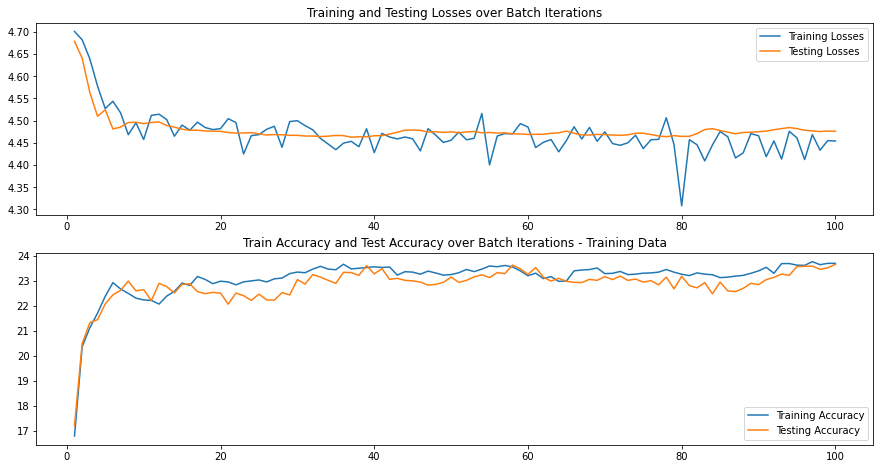

In [91]:
train(model=linear_net(), retrain=False, EPOCHS=5, get_confusion_matrix=False)

In [86]:
# input_size is the length of each row, here it is 667
# hidden_size is the number of nodes in each hidden layer
# num_layers is the number of hidden layers to use
# num_classes is the number of classes and therefore the size of the output

class LSTM_Classifier(nn.Module):
    def __init__(self, input_size = ds[0][0].size, hidden_size = 110, num_layers = 3, num_classes = 110):
        super(LSTM_Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # bidirectional means that the state of a row will depend on previous states and states after the row
        self.bidirectional = True
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=self.bidirectional)
        # batch_first=True means: # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size
        if self.bidirectional:
            # since bidirectional we need twice as many hidden layers and weights
            self.fc = nn.Linear(hidden_size*2, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        # making x a rolled out 2d image
        x = x.view(-1, 1, ds[0][0].size).float().to(device) 
        # setting initial weight and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        if self.bidirectional:
            # since bidirectional we need twice as many hidden layers and weights
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
        
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return F.log_softmax(out, dim=1)

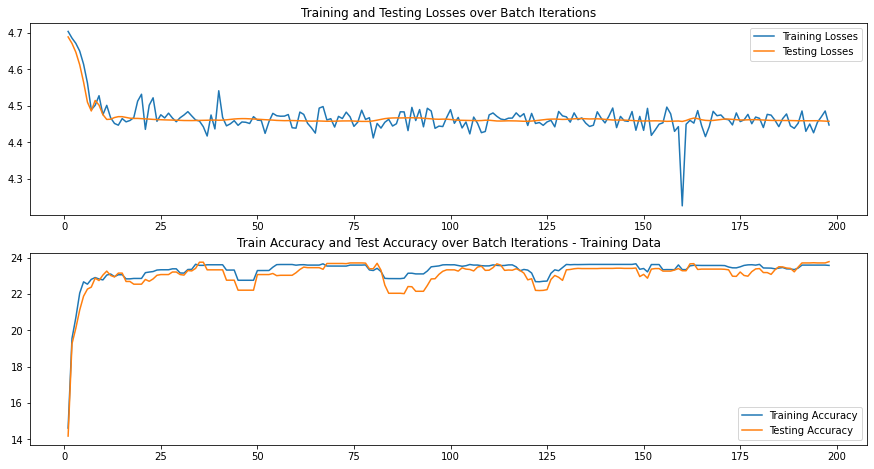

In [89]:
train(model=LSTM_Classifier(), retrain=False, EPOCHS=5, get_confusion_matrix=False)

Making a prediction with a raw user input

Load a model

In [170]:
user_input = [2,2,2,2,2,2,2,2,2]

In [171]:
torch_input = torch.tensor(np.eye(110)[user_input])

torch input is the same as X0 from before, don't need to index anymore

In [172]:
model = LSTM_Classifier()
model.load_state_dict(torch.load(r"C:\Users\roder\Projects\DOTA_Hero_Prediction_Project\LSTM_Classifier"))
output = model(torch_input)
output

tensor([[-4.0088, -4.8127, -5.2351, -5.0774, -4.0648, -5.4673, -3.8923, -3.9329,
         -4.1090, -5.9227, -3.4974, -4.8490, -5.5407, -3.9958, -5.3884, -4.9140,
         -5.6319, -5.1301, -4.4944, -4.9035, -3.4127, -4.5760, -5.3390, -4.0980,
         -4.1570, -4.9278, -3.7287, -5.2690, -3.9520, -4.7417, -4.8801, -5.0429,
         -5.2934, -5.0714, -4.3790, -5.5206, -5.6173, -3.8176, -5.0548, -5.0772,
         -4.2562, -5.4782, -4.2427, -5.8643, -4.5806, -4.9253, -5.4311, -5.6744,
         -3.9528, -4.6873, -6.0701, -4.9532, -5.2126, -4.9588, -5.3765, -4.5742,
         -6.0786, -4.8615, -5.4232, -5.5943, -4.1933, -5.5744, -5.1135, -5.8802,
         -6.6146, -4.3383, -4.1261, -4.0593, -4.7375, -4.2289, -4.4443, -3.9333,
         -3.7264, -4.1947, -5.5614, -6.2164, -6.2423, -5.7172, -6.4408, -5.4337,
         -5.5157, -5.6743, -4.7699, -4.5038, -4.0550, -4.6729, -5.2787, -6.1686,
         -5.3776, -5.6018, -6.3015, -4.0594, -5.5389, -5.6808, -5.4848, -4.8206,
         -5.2657, -4.9442, -

Actually using softmax not log softmax here - not the same as the model but need a probability!

In [173]:
probabilities = F.softmax(output, dim=1)
probabilities

tensor([[0.0182, 0.0081, 0.0053, 0.0062, 0.0172, 0.0042, 0.0204, 0.0196, 0.0164,
         0.0027, 0.0303, 0.0078, 0.0039, 0.0184, 0.0046, 0.0073, 0.0036, 0.0059,
         0.0112, 0.0074, 0.0330, 0.0103, 0.0048, 0.0166, 0.0157, 0.0072, 0.0240,
         0.0051, 0.0192, 0.0087, 0.0076, 0.0065, 0.0050, 0.0063, 0.0125, 0.0040,
         0.0036, 0.0220, 0.0064, 0.0062, 0.0142, 0.0042, 0.0144, 0.0028, 0.0102,
         0.0073, 0.0044, 0.0034, 0.0192, 0.0092, 0.0023, 0.0071, 0.0054, 0.0070,
         0.0046, 0.0103, 0.0023, 0.0077, 0.0044, 0.0037, 0.0151, 0.0038, 0.0060,
         0.0028, 0.0013, 0.0131, 0.0161, 0.0173, 0.0088, 0.0146, 0.0117, 0.0196,
         0.0241, 0.0151, 0.0038, 0.0020, 0.0019, 0.0033, 0.0016, 0.0044, 0.0040,
         0.0034, 0.0085, 0.0111, 0.0173, 0.0093, 0.0051, 0.0021, 0.0046, 0.0037,
         0.0018, 0.0173, 0.0039, 0.0034, 0.0041, 0.0081, 0.0052, 0.0071, 0.0195,
         0.0056, 0.0057, 0.0020, 0.0192, 0.0030, 0.0161, 0.0061, 0.0038, 0.0078,
         0.0021, 0.0150]], g

In [174]:
predictions = torch.topk(output, k=10).indices.tolist()[0]
predictions

[20, 10, 72, 26, 37, 6, 7, 71, 98, 102]

In [175]:
df_hero_names.head()

,name,hero_id,localized_name
0,npc_dota_hero_antimage,-1,Anti-Mage
1,npc_dota_hero_axe,0,Axe
2,npc_dota_hero_bane,1,Bane
3,npc_dota_hero_bloodseeker,2,Bloodseeker
4,npc_dota_hero_crystal_maiden,3,Crystal Maiden


In [176]:
len(df_hero_names)

112

Getting the name from the predictions - got to be careful here since "df_hero_names" hasn't had the hero_id correction applied so doing that now

In [177]:
hero_checker = df_hero_names

In [178]:
hero_checker['hero_id'] = hero_checker['hero_id'].apply(func)

Should be ok now

In [179]:
hero_checker.head()

,name,hero_id,localized_name
0,npc_dota_hero_antimage,-2,Anti-Mage
1,npc_dota_hero_axe,-1,Axe
2,npc_dota_hero_bane,0,Bane
3,npc_dota_hero_bloodseeker,1,Bloodseeker
4,npc_dota_hero_crystal_maiden,2,Crystal Maiden


Getting heroes

In [180]:
hero_outputs = hero_checker['localized_name'][hero_checker['hero_id'].isin(predictions)].tolist()
hero_outputs

['Mirana',
 'Morphling',
 'Puck',
 'Kunkka',
 'Riki',
 'Death Prophet',
 'Lycan',
 'Brewmaster',
 'Legion Commander',
 'Terrorblade']

In [181]:
probability_output = probabilities[0][predictions].tolist()
probability_output

[0.032953571528196335,
 0.03027528151869774,
 0.024080514907836914,
 0.02402523346245289,
 0.021981343626976013,
 0.020398149266839027,
 0.019587736576795578,
 0.01957988739013672,
 0.01948363147675991,
 0.019216345623135567]

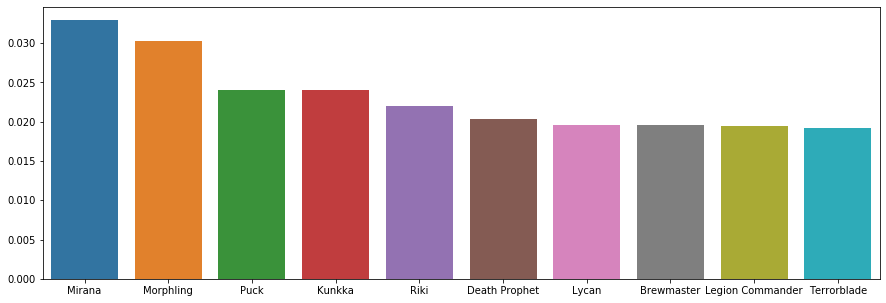

In [182]:
fig = plt.figure(figsize=(15,5))
sns.barplot(hero_outputs, probability_output)